# Temporal TDA Analysis: Coverage Evolution During Play Development

1. **Track H₁ features (gaps) over time** - How do coverage holes evolve?
2. **Pre-snap disguise detection** - Compare topology at ball_snap vs pass_forward
3. **Time-to-gap metrics** - When do exploitable gaps appear?
4. **Temporal signatures** - Do complete/incomplete passes have different topological evolution?

## Data Structure
- 10Hz tracking data (~50-60 frames per play)
- Events: ball_snap → pass_forward → pass_arrived → pass_outcome

In [1]:
# Imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, str(Path('../src').resolve()))

from tda_analysis import DefensiveCoverageTDA

print("Imports successful!")

Imports successful!


In [2]:
# Configuration
RAW_DATA_PATH = Path('../data/raw')
PROCESSED_PATH = Path('../data/processed')
RESULTS_PATH = Path('../results')

# Create temporal results directory
TEMPORAL_RESULTS = RESULTS_PATH / 'temporal'
TEMPORAL_RESULTS.mkdir(parents=True, exist_ok=True)

print(f"Raw data path: {RAW_DATA_PATH}")
print(f"Results will be saved to: {TEMPORAL_RESULTS}")

Raw data path: ..\data\raw
Results will be saved to: ..\results\temporal


## 1. Load Raw Tracking Data with Full Temporal Sequence

In [3]:
# Load one week of data to start (for memory efficiency)
week1_path = RAW_DATA_PATH / 'week1.csv'

if week1_path.exists():
    print("Loading week1.csv...")
    tracking_df = pd.read_csv(week1_path)
    print(f"Loaded {len(tracking_df):,} rows")
    print(f"Columns: {list(tracking_df.columns)}")
else:
    print(f"File not found: {week1_path}")
    print("Available files:")
    for f in RAW_DATA_PATH.glob('*.csv'):
        print(f"  {f.name}")

Loading week1.csv...
Loaded 986,022 rows
Columns: ['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route']


In [4]:
# Load plays metadata for pass result labels
plays_path = RAW_DATA_PATH / 'plays.csv'

if plays_path.exists():
    plays_df = pd.read_csv(plays_path)
    print(f"Loaded {len(plays_df):,} plays")
    
    # Filter to passing plays
    pass_plays = plays_df[plays_df['passResult'].notna()].copy()
    print(f"Passing plays: {len(pass_plays):,}")
    print(f"\nPass results distribution:")
    print(pass_plays['passResult'].value_counts())
else:
    print(f"File not found: {plays_path}")

Loaded 19,239 plays
Passing plays: 19,237

Pass results distribution:
passResult
C     11370
I      6135
S      1308
IN      420
R         4
Name: count, dtype: int64


In [5]:
# Examine temporal structure of a sample play
sample_play = tracking_df.groupby(['gameId', 'playId']).first().reset_index().iloc[0]
game_id, play_id = sample_play['gameId'], sample_play['playId']

play_data = tracking_df[(tracking_df['gameId'] == game_id) & 
                        (tracking_df['playId'] == play_id)]

print(f"Sample play: Game {game_id}, Play {play_id}")
print(f"Total rows: {len(play_data)}")
print(f"Unique frames: {play_data['frameId'].nunique()}")
print(f"Frame range: {play_data['frameId'].min()} to {play_data['frameId'].max()}")
print(f"\nEvents in this play:")
events = play_data.groupby('frameId')['event'].first().dropna()
for frame, event in events.items():
    print(f"  Frame {frame}: {event}")

Sample play: Game 2018090600, Play 75
Total rows: 826
Unique frames: 59
Frame range: 1 to 59

Events in this play:
  Frame 11: ball_snap
  Frame 36: pass_forward
  Frame 47: pass_arrived
  Frame 52: pass_outcome_caught
  Frame 58: out_of_bounds


## 2. Extract Multi-Frame Defensive Formations

For each play, we'll extract defensive positions at key time points:
- **ball_snap**: Pre-snap alignment (t=0)
- **pass_forward**: Ball release
- **pass_arrived**: Ball arrival at target

Plus intermediate frames to capture continuous evolution.

In [6]:
def extract_temporal_formations(tracking_df, plays_df, n_intermediate_frames=5):
    """
    Extract defensive formations at multiple time points for each play.
    
    Parameters:
    -----------
    tracking_df : DataFrame with full tracking data
    plays_df : DataFrame with play metadata
    n_intermediate_frames : Number of frames between key events
    
    Returns:
    --------
    dict: {(gameId, playId): {'frames': [...], 'events': [...], 'formations': [...]}}
    """
    
    # Merge to get possession team info
    merged = tracking_df.merge(
        plays_df[['gameId', 'playId', 'possessionTeam', 'passResult']],
        on=['gameId', 'playId'],
        how='inner'
    )
    
    # Filter to defensive players only (team != possession team, not football)
    merged = merged[merged['team'] != 'football']
    merged = merged[merged['team'] != merged['possessionTeam']]
    
    results = {}
    plays = merged.groupby(['gameId', 'playId'])
    
    for (game_id, play_id), play_data in tqdm(plays, desc="Extracting temporal formations"):
        # Find key event frames
        events_df = play_data.groupby('frameId')['event'].first().dropna()
        
        snap_frame = None
        pass_frame = None
        arrive_frame = None
        
        for frame, event in events_df.items():
            if event == 'ball_snap':
                snap_frame = frame
            elif event == 'pass_forward':
                pass_frame = frame
            elif event in ['pass_arrived', 'pass_outcome_caught', 'pass_outcome_incomplete']:
                arrive_frame = frame
        
        # Skip if missing key events
        if snap_frame is None or pass_frame is None:
            continue
        
        # Build list of frames to extract
        frames_to_extract = [snap_frame]  # Start with snap
        
        # Add intermediate frames between snap and pass_forward
        if pass_frame > snap_frame:
            intermediate = np.linspace(snap_frame, pass_frame, n_intermediate_frames + 2, dtype=int)[1:-1]
            frames_to_extract.extend(intermediate.tolist())
        
        frames_to_extract.append(pass_frame)  # Add pass_forward
        
        # Add frames after pass_forward if available
        if arrive_frame and arrive_frame > pass_frame:
            post_pass = np.linspace(pass_frame, arrive_frame, 3, dtype=int)[1:]
            frames_to_extract.extend(post_pass.tolist())
        
        # Remove duplicates and sort
        frames_to_extract = sorted(set(frames_to_extract))
        
        # Extract formations at each frame
        formations = []
        frame_events = []
        
        for frame in frames_to_extract:
            frame_data = play_data[play_data['frameId'] == frame]
            if len(frame_data) >= 5:  # Need minimum defenders
                positions = frame_data[['x', 'y']].values
                formations.append(positions)
                # Record event if any
                event = events_df.get(frame, None)
                frame_events.append(event)
        
        if len(formations) >= 3:  # Need at least 3 time points
            pass_result = play_data['passResult'].iloc[0]
            results[(game_id, play_id)] = {
                'frames': frames_to_extract[:len(formations)],
                'events': frame_events,
                'formations': formations,
                'pass_result': pass_result,
                'snap_frame': snap_frame,
                'pass_frame': pass_frame
            }
    
    return results

print("Function defined.")

Function defined.


In [7]:
# Extract temporal formations
temporal_data = extract_temporal_formations(tracking_df, plays_df, n_intermediate_frames=5)

print(f"\nExtracted temporal data for {len(temporal_data)} plays")

# Show sample
sample_key = list(temporal_data.keys())[0]
sample = temporal_data[sample_key]
print(f"\nSample play {sample_key}:")
print(f"  Frames: {sample['frames']}")
print(f"  Events: {sample['events']}")
print(f"  Formations: {len(sample['formations'])} snapshots")
print(f"  Pass result: {sample['pass_result']}")

Extracting temporal formations: 100%|██████████| 1034/1034 [00:14<00:00, 72.16it/s]



Extracted temporal data for 962 plays

Sample play (np.int64(2018090600), np.int64(75)):
  Frames: [11, 15, 19, 23, 27, 31, 36, 44, 52]
  Events: ['ball_snap', None, None, None, None, None, 'pass_forward', None, 'pass_outcome_caught']
  Formations: 9 snapshots
  Pass result: C


## 3. Compute Temporal Persistence

For each play, compute persistence diagrams at each time point to track topological evolution.

In [8]:
def compute_temporal_persistence(temporal_data, max_dimension=1):
    """
    Compute persistence diagrams at each time point for all plays.
    
    Returns:
    --------
    dict: Same structure as input, with 'persistence' key added
    """
    tda = DefensiveCoverageTDA(max_dimension=max_dimension)
    
    for key in tqdm(temporal_data.keys(), desc="Computing temporal persistence"):
        formations = temporal_data[key]['formations']
        
        persistence_sequence = []
        for formation in formations:
            result = tda.compute_persistence(formation)
            persistence_sequence.append(result)
        
        temporal_data[key]['persistence'] = persistence_sequence
    
    return temporal_data

# Compute persistence
temporal_data = compute_temporal_persistence(temporal_data)
print("\nTemporal persistence computed for all plays.")

Computing temporal persistence: 100%|██████████| 962/962 [00:08<00:00, 112.91it/s]


Temporal persistence computed for all plays.


## 4. Extract Temporal Topological Features

Convert persistence diagrams to time series of topological features.

In [9]:
def extract_temporal_features(temporal_data, significance_threshold=1.0):
    """
    Extract time series of topological features from persistence sequences.
    
    Features at each time point:
    - H0_components: Number of connected components (defender clusters)
    - H1_gaps: Number of significant coverage gaps
    - H1_max_persistence: Size of largest gap (yards)
    - H1_total_persistence: Total gap size
    """
    
    feature_records = []
    
    for (game_id, play_id), data in temporal_data.items():
        frames = data['frames']
        events = data['events']
        persistence_seq = data['persistence']
        pass_result = data['pass_result']
        snap_frame = data['snap_frame']
        
        for i, (frame, event, pers) in enumerate(zip(frames, events, persistence_seq)):
            # Time relative to snap (in frames, 10Hz = 0.1s per frame)
            time_from_snap = (frame - snap_frame) / 10.0  # seconds
            
            # H0 features
            h0_dgm = pers['dgms'][0]
            h0_finite = h0_dgm[np.isfinite(h0_dgm).all(axis=1)]
            h0_components = len(h0_dgm)  # Including infinite point
            
            # H1 features (gaps)
            h1_dgm = pers['dgms'][1]
            h1_finite = h1_dgm[np.isfinite(h1_dgm).all(axis=1)]
            
            if len(h1_finite) > 0:
                h1_persistence = h1_finite[:, 1] - h1_finite[:, 0]
                significant_gaps = h1_persistence[h1_persistence > significance_threshold]
                
                h1_gaps = len(significant_gaps)
                h1_max = h1_persistence.max() if len(h1_persistence) > 0 else 0
                h1_total = h1_persistence.sum()
            else:
                h1_gaps = 0
                h1_max = 0
                h1_total = 0
            
            feature_records.append({
                'gameId': game_id,
                'playId': play_id,
                'frame': frame,
                'time_from_snap': time_from_snap,
                'event': event,
                'time_index': i,
                'H0_components': h0_components,
                'H1_gaps': h1_gaps,
                'H1_max_persistence': h1_max,
                'H1_total_persistence': h1_total,
                'pass_result': pass_result
            })
    
    return pd.DataFrame(feature_records)

# Extract features
temporal_features = extract_temporal_features(temporal_data)
print(f"Extracted {len(temporal_features):,} time-point observations")
print(f"From {temporal_features['playId'].nunique()} plays")
print(f"\nFeature columns: {list(temporal_features.columns)}")

Extracted 8,644 time-point observations
From 865 plays

Feature columns: ['gameId', 'playId', 'frame', 'time_from_snap', 'event', 'time_index', 'H0_components', 'H1_gaps', 'H1_max_persistence', 'H1_total_persistence', 'pass_result']


In [10]:
# Preview temporal features
print("Sample temporal features (one play):")
sample_play_id = temporal_features['playId'].iloc[0]
sample_game_id = temporal_features['gameId'].iloc[0]
display_cols = ['time_from_snap', 'event', 'H0_components', 'H1_gaps', 'H1_max_persistence']
print(temporal_features[(temporal_features['playId'] == sample_play_id) & 
                        (temporal_features['gameId'] == sample_game_id)][display_cols].to_string())

Sample temporal features (one play):
   time_from_snap                event  H0_components  H1_gaps  H1_max_persistence
0             0.0            ball_snap             13        0            0.981044
1             0.4                 None             13        0            0.924697
2             0.8                 None             13        0            0.407453
3             1.2                 None             13        0            0.477281
4             1.6                 None             13        0            0.765461
5             2.0                 None             13        0            0.554272
6             2.5         pass_forward             13        0            0.918272
7             3.3                 None             13        0            0.000000
8             4.1  pass_outcome_caught             13        0            0.122103


## 5. Analyze Gap Evolution Over Time

Key question: How do coverage gaps (H₁ features) evolve during plays?

In [11]:
# Aggregate by time and pass result
temporal_features['is_complete'] = temporal_features['pass_result'] == 'C'

# Group by time_index (normalized time within play) and completion
time_grouped = temporal_features.groupby(['time_index', 'is_complete']).agg({
    'H1_gaps': 'mean',
    'H1_max_persistence': 'mean',
    'H1_total_persistence': 'mean',
    'H0_components': 'mean',
    'time_from_snap': 'mean'
}).reset_index()

print("Average features by time index and completion:")
print(time_grouped.to_string())

Average features by time index and completion:
    time_index  is_complete   H1_gaps  H1_max_persistence  H1_total_persistence  H0_components  time_from_snap
0            0        False  0.719794            1.314875              1.831411      13.807198        0.000000
1            0         True  0.825480            1.488436              2.111013      13.670157        0.000000
2            1        False  0.706941            1.287754              1.748645      13.807198        0.461183
3            1         True  0.811518            1.494872              2.084954      13.670157        0.392321
4            2        False  0.591260            1.126233              1.462457      13.807198        0.970694
5            2         True  0.712042            1.388405              1.856714      13.670157        0.832810
6            3        False  0.480720            0.993370              1.229335      13.807198        1.484062
7            3         True  0.600349            1.219171        

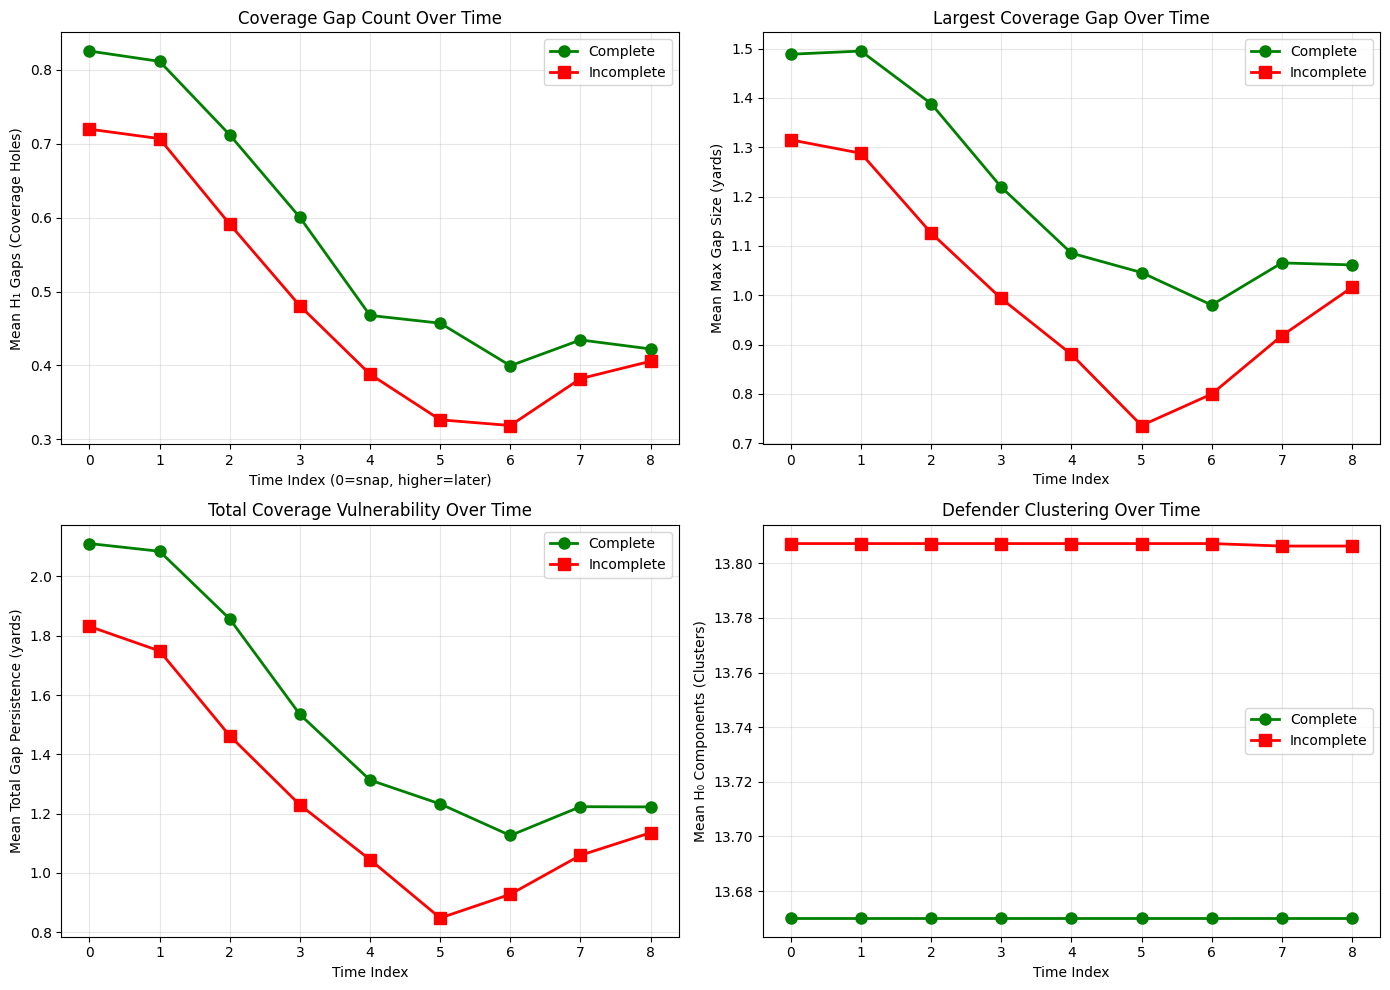


Saved to ..\results\temporal\gap_evolution.png


In [12]:
# Visualize gap evolution: Complete vs Incomplete passes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

complete = time_grouped[time_grouped['is_complete'] == True]
incomplete = time_grouped[time_grouped['is_complete'] == False]

# H1 Gaps over time
ax1 = axes[0, 0]
ax1.plot(complete['time_index'], complete['H1_gaps'], 'g-o', label='Complete', linewidth=2, markersize=8)
ax1.plot(incomplete['time_index'], incomplete['H1_gaps'], 'r-s', label='Incomplete', linewidth=2, markersize=8)
ax1.set_xlabel('Time Index (0=snap, higher=later)')
ax1.set_ylabel('Mean H₁ Gaps (Coverage Holes)')
ax1.set_title('Coverage Gap Count Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Max gap size over time
ax2 = axes[0, 1]
ax2.plot(complete['time_index'], complete['H1_max_persistence'], 'g-o', label='Complete', linewidth=2, markersize=8)
ax2.plot(incomplete['time_index'], incomplete['H1_max_persistence'], 'r-s', label='Incomplete', linewidth=2, markersize=8)
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Mean Max Gap Size (yards)')
ax2.set_title('Largest Coverage Gap Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Total gap persistence over time
ax3 = axes[1, 0]
ax3.plot(complete['time_index'], complete['H1_total_persistence'], 'g-o', label='Complete', linewidth=2, markersize=8)
ax3.plot(incomplete['time_index'], incomplete['H1_total_persistence'], 'r-s', label='Incomplete', linewidth=2, markersize=8)
ax3.set_xlabel('Time Index')
ax3.set_ylabel('Mean Total Gap Persistence (yards)')
ax3.set_title('Total Coverage Vulnerability Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# H0 Components (clustering) over time
ax4 = axes[1, 1]
ax4.plot(complete['time_index'], complete['H0_components'], 'g-o', label='Complete', linewidth=2, markersize=8)
ax4.plot(incomplete['time_index'], incomplete['H0_components'], 'r-s', label='Incomplete', linewidth=2, markersize=8)
ax4.set_xlabel('Time Index')
ax4.set_ylabel('Mean H₀ Components (Clusters)')
ax4.set_title('Defender Clustering Over Time')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(TEMPORAL_RESULTS / 'gap_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved to {TEMPORAL_RESULTS / 'gap_evolution.png'}")

## 6. Pre-Snap Disguise Detection

Compare topology at ball_snap vs pass_forward to detect coverage disguises.

**Hypothesis**: Large topological changes post-snap indicate disguised coverage.

In [13]:
from persim import bottleneck

def compute_disguise_metrics(temporal_data):
    """
    Compute topological change between snap and pass_forward.
    
    Disguise metric = bottleneck distance between persistence diagrams.
    """
    
    disguise_records = []
    
    for (game_id, play_id), data in tqdm(temporal_data.items(), desc="Computing disguise metrics"):
        events = data['events']
        persistence_seq = data['persistence']
        pass_result = data['pass_result']
        
        # Find snap and pass_forward indices
        snap_idx = None
        pass_idx = None
        
        for i, event in enumerate(events):
            if event == 'ball_snap':
                snap_idx = i
            elif event == 'pass_forward':
                pass_idx = i
        
        if snap_idx is None or pass_idx is None:
            continue
        
        # Get persistence diagrams
        snap_pers = persistence_seq[snap_idx]
        pass_pers = persistence_seq[pass_idx]
        
        # Compute bottleneck distances for H0 and H1
        try:
            # H0 change (clustering change)
            h0_snap = snap_pers['dgms'][0]
            h0_pass = pass_pers['dgms'][0]
            # Remove infinite points for comparison
            h0_snap_finite = h0_snap[np.isfinite(h0_snap).all(axis=1)]
            h0_pass_finite = h0_pass[np.isfinite(h0_pass).all(axis=1)]
            
            if len(h0_snap_finite) > 0 and len(h0_pass_finite) > 0:
                h0_change = bottleneck(h0_snap_finite, h0_pass_finite)
            else:
                h0_change = 0
            
            # H1 change (gap structure change)
            h1_snap = snap_pers['dgms'][1]
            h1_pass = pass_pers['dgms'][1]
            h1_snap_finite = h1_snap[np.isfinite(h1_snap).all(axis=1)]
            h1_pass_finite = h1_pass[np.isfinite(h1_pass).all(axis=1)]
            
            # Handle empty diagrams
            if len(h1_snap_finite) == 0:
                h1_snap_finite = np.array([[0, 0]])
            if len(h1_pass_finite) == 0:
                h1_pass_finite = np.array([[0, 0]])
            
            h1_change = bottleneck(h1_snap_finite, h1_pass_finite)
            
            # Total disguise metric
            total_change = h0_change + h1_change
            
            disguise_records.append({
                'gameId': game_id,
                'playId': play_id,
                'H0_change': h0_change,
                'H1_change': h1_change,
                'total_disguise': total_change,
                'pass_result': pass_result
            })
        except Exception as e:
            continue
    
    return pd.DataFrame(disguise_records)

# Compute disguise metrics
disguise_df = compute_disguise_metrics(temporal_data)
print(f"Computed disguise metrics for {len(disguise_df)} plays")

Computing disguise metrics: 100%|██████████| 962/962 [00:10<00:00, 90.96it/s] 

Computed disguise metrics for 962 plays


In [14]:
# Analyze disguise by pass result
disguise_df['is_complete'] = disguise_df['pass_result'] == 'C'

print("Disguise metrics by pass result:")
print(disguise_df.groupby('is_complete')[['H0_change', 'H1_change', 'total_disguise']].agg(['mean', 'std', 'median']))

# Statistical test
from scipy import stats

complete_disguise = disguise_df[disguise_df['is_complete']]['total_disguise']
incomplete_disguise = disguise_df[~disguise_df['is_complete']]['total_disguise']

t_stat, p_value = stats.ttest_ind(complete_disguise, incomplete_disguise)
print(f"\nT-test for disguise difference: t={t_stat:.3f}, p={p_value:.4f}")

Disguise metrics by pass result:
            H0_change                     H1_change                      \
                 mean       std    median      mean       std    median   
is_complete                                                               
False        4.606874  2.323284  4.164650  0.833515  0.636846  0.725679   
True         3.672203  1.808943  3.296125  0.908699  0.589265  0.811028   

            total_disguise                      
                      mean       std    median  
is_complete                                     
False             5.440390  2.427769  4.967497  
True              4.580902  1.894817  4.184140  

T-test for disguise difference: t=-6.153, p=0.0000


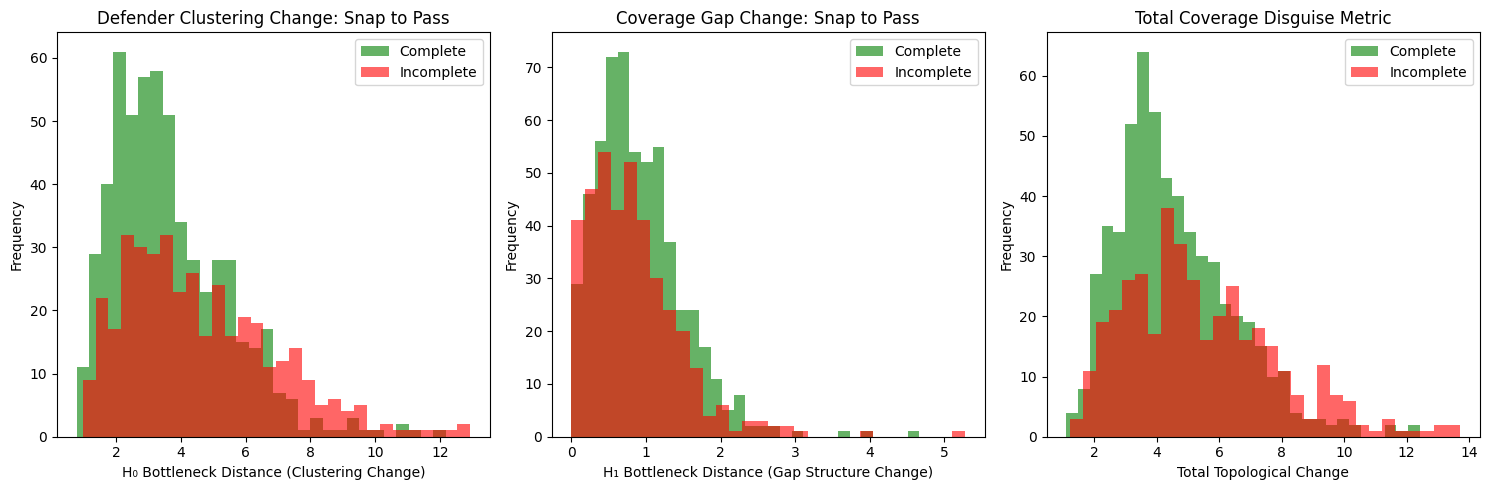

In [15]:
# Visualize disguise distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# H0 change distribution
ax1 = axes[0]
ax1.hist(disguise_df[disguise_df['is_complete']]['H0_change'], bins=30, alpha=0.6, label='Complete', color='green')
ax1.hist(disguise_df[~disguise_df['is_complete']]['H0_change'], bins=30, alpha=0.6, label='Incomplete', color='red')
ax1.set_xlabel('H₀ Bottleneck Distance (Clustering Change)')
ax1.set_ylabel('Frequency')
ax1.set_title('Defender Clustering Change: Snap to Pass')
ax1.legend()

# H1 change distribution
ax2 = axes[1]
ax2.hist(disguise_df[disguise_df['is_complete']]['H1_change'], bins=30, alpha=0.6, label='Complete', color='green')
ax2.hist(disguise_df[~disguise_df['is_complete']]['H1_change'], bins=30, alpha=0.6, label='Incomplete', color='red')
ax2.set_xlabel('H₁ Bottleneck Distance (Gap Structure Change)')
ax2.set_ylabel('Frequency')
ax2.set_title('Coverage Gap Change: Snap to Pass')
ax2.legend()

# Total disguise
ax3 = axes[2]
ax3.hist(disguise_df[disguise_df['is_complete']]['total_disguise'], bins=30, alpha=0.6, label='Complete', color='green')
ax3.hist(disguise_df[~disguise_df['is_complete']]['total_disguise'], bins=30, alpha=0.6, label='Incomplete', color='red')
ax3.set_xlabel('Total Topological Change')
ax3.set_ylabel('Frequency')
ax3.set_title('Total Coverage Disguise Metric')
ax3.legend()

plt.tight_layout()
plt.savefig(TEMPORAL_RESULTS / 'disguise_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Time-to-Gap Analysis

When during the play do significant gaps first appear?

In [16]:
def compute_time_to_gap(temporal_features, gap_threshold=1.0):
    """
    For each play, find when the first significant gap appears.
    
    Returns time_from_snap when H1_max_persistence first exceeds threshold.
    """
    
    time_to_gap_records = []
    
    for (game_id, play_id), play_data in temporal_features.groupby(['gameId', 'playId']):
        play_data = play_data.sort_values('time_from_snap')
        pass_result = play_data['pass_result'].iloc[0]
        
        # Find first time with significant gap
        gap_times = play_data[play_data['H1_max_persistence'] > gap_threshold]['time_from_snap']
        
        if len(gap_times) > 0:
            first_gap_time = gap_times.iloc[0]
            had_gap = True
        else:
            first_gap_time = np.nan
            had_gap = False
        
        # Also track max gap size achieved
        max_gap = play_data['H1_max_persistence'].max()
        
        time_to_gap_records.append({
            'gameId': game_id,
            'playId': play_id,
            'first_gap_time': first_gap_time,
            'had_significant_gap': had_gap,
            'max_gap_size': max_gap,
            'pass_result': pass_result
        })
    
    return pd.DataFrame(time_to_gap_records)

# Compute time-to-gap
ttg_df = compute_time_to_gap(temporal_features, gap_threshold=1.5)
ttg_df['is_complete'] = ttg_df['pass_result'] == 'C'

print("Time-to-Gap Analysis:")
print(f"\nPlays with significant gap: {ttg_df['had_significant_gap'].sum()} / {len(ttg_df)}")
print(f"  Complete passes: {ttg_df[ttg_df['is_complete']]['had_significant_gap'].mean():.1%}")
print(f"  Incomplete passes: {ttg_df[~ttg_df['is_complete']]['had_significant_gap'].mean():.1%}")

Time-to-Gap Analysis:

Plays with significant gap: 758 / 962
  Complete passes: 78.5%
  Incomplete passes: 79.2%



For plays WITH significant gaps:
                 mean  median       std
is_complete                            
False        1.163961     0.4  1.628022
True         0.875333     0.0  1.311654


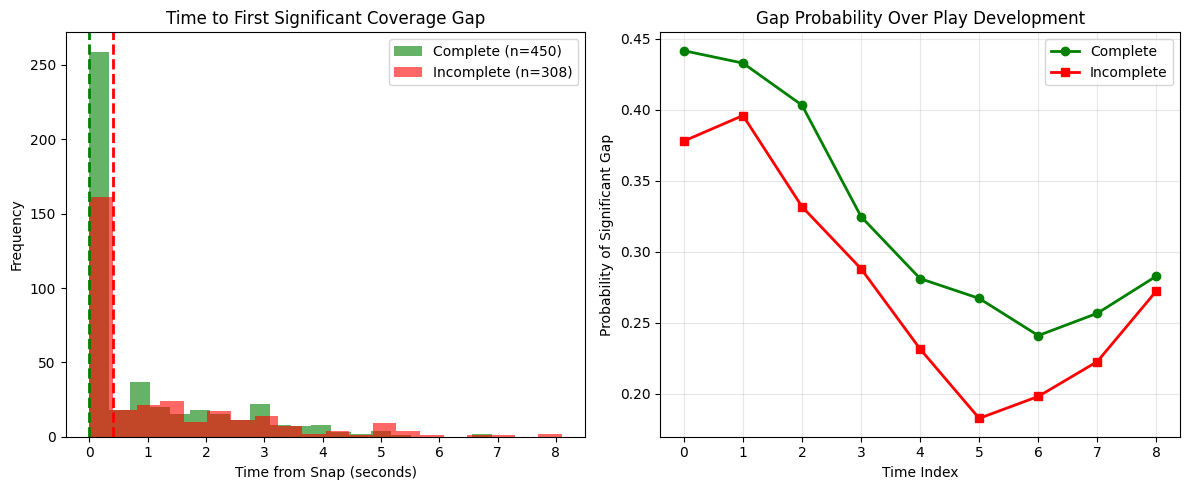

In [17]:
# Analyze time-to-gap by pass result
ttg_with_gap = ttg_df[ttg_df['had_significant_gap']]

print("\nFor plays WITH significant gaps:")
print(ttg_with_gap.groupby('is_complete')['first_gap_time'].agg(['mean', 'median', 'std']))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Time to first gap
ax1 = axes[0]
complete_ttg = ttg_with_gap[ttg_with_gap['is_complete']]['first_gap_time'].dropna()
incomplete_ttg = ttg_with_gap[~ttg_with_gap['is_complete']]['first_gap_time'].dropna()

ax1.hist(complete_ttg, bins=20, alpha=0.6, label=f'Complete (n={len(complete_ttg)})', color='green')
ax1.hist(incomplete_ttg, bins=20, alpha=0.6, label=f'Incomplete (n={len(incomplete_ttg)})', color='red')
ax1.axvline(complete_ttg.median(), color='green', linestyle='--', linewidth=2)
ax1.axvline(incomplete_ttg.median(), color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Time from Snap (seconds)')
ax1.set_ylabel('Frequency')
ax1.set_title('Time to First Significant Coverage Gap')
ax1.legend()

# Gap probability over time
ax2 = axes[1]
gap_prob = temporal_features.copy()
gap_prob['has_gap'] = gap_prob['H1_max_persistence'] > 1.5
gap_by_time = gap_prob.groupby(['time_index', 'is_complete'])['has_gap'].mean().reset_index()

complete_prob = gap_by_time[gap_by_time['is_complete']]
incomplete_prob = gap_by_time[~gap_by_time['is_complete']]

ax2.plot(complete_prob['time_index'], complete_prob['has_gap'], 'g-o', label='Complete', linewidth=2)
ax2.plot(incomplete_prob['time_index'], incomplete_prob['has_gap'], 'r-s', label='Incomplete', linewidth=2)
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Probability of Significant Gap')
ax2.set_title('Gap Probability Over Play Development')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(TEMPORAL_RESULTS / 'time_to_gap.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Temporal Betti Curves

Track β₀(t) and β₁(t) as functions of both:
- Filtration parameter (scale/yards)
- Time during play

In [18]:
def compute_betti_at_scale(dgm, scale):
    """Count features alive at a given scale."""
    finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
    if len(finite_dgm) == 0:
        return 0
    alive = (finite_dgm[:, 0] <= scale) & (finite_dgm[:, 1] > scale)
    return alive.sum()

def compute_temporal_betti_surface(temporal_data, scales=np.linspace(0, 15, 50)):
    """
    Compute Betti numbers as a function of both scale and time.
    
    Returns 2D arrays: β(scale, time)
    """
    
    # Aggregate across plays
    complete_h1 = []
    incomplete_h1 = []
    
    for (game_id, play_id), data in temporal_data.items():
        persistence_seq = data['persistence']
        pass_result = data['pass_result']
        is_complete = pass_result == 'C'
        
        # Compute Betti curve at each time point
        play_betti = []
        for pers in persistence_seq:
            h1_dgm = pers['dgms'][1]
            betti_curve = [compute_betti_at_scale(h1_dgm, s) for s in scales]
            play_betti.append(betti_curve)
        
        if is_complete:
            complete_h1.append(play_betti)
        else:
            incomplete_h1.append(play_betti)
    
    return {
        'scales': scales,
        'complete_h1': complete_h1,
        'incomplete_h1': incomplete_h1
    }

# Compute
betti_surfaces = compute_temporal_betti_surface(temporal_data)
print(f"Computed Betti surfaces for {len(betti_surfaces['complete_h1'])} complete and {len(betti_surfaces['incomplete_h1'])} incomplete passes")

Computed Betti surfaces for 573 complete and 389 incomplete passes


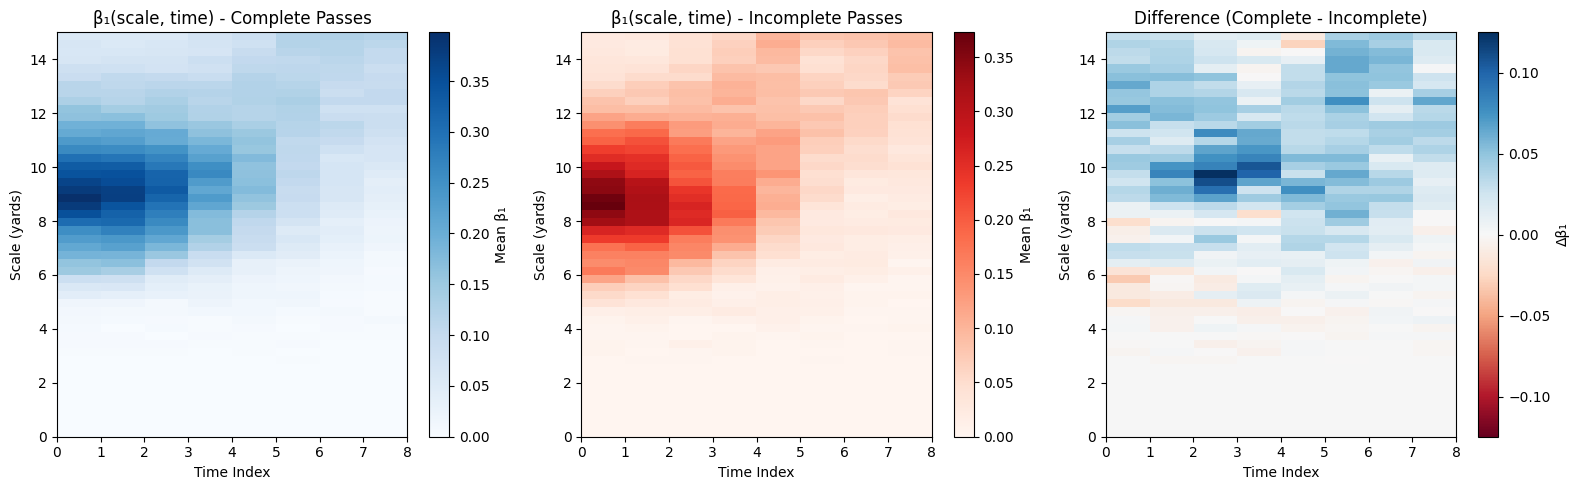

In [19]:
# Average Betti surfaces
def pad_and_average(surfaces_list, max_time=8):
    """Pad surfaces to same time length and average."""
    padded = []
    for surf in surfaces_list:
        if len(surf) >= max_time:
            padded.append(surf[:max_time])
        else:
            # Pad with last value
            pad_length = max_time - len(surf)
            padded.append(surf + [surf[-1]] * pad_length)
    
    return np.array(padded).mean(axis=0)

scales = betti_surfaces['scales']
complete_avg = pad_and_average(betti_surfaces['complete_h1'])
incomplete_avg = pad_and_average(betti_surfaces['incomplete_h1'])

# Plot as heatmaps
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Complete passes
im1 = axes[0].imshow(complete_avg.T, aspect='auto', origin='lower', 
                     extent=[0, complete_avg.shape[0], scales[0], scales[-1]], cmap='Blues')
axes[0].set_xlabel('Time Index')
axes[0].set_ylabel('Scale (yards)')
axes[0].set_title('β₁(scale, time) - Complete Passes')
plt.colorbar(im1, ax=axes[0], label='Mean β₁')

# Incomplete passes
im2 = axes[1].imshow(incomplete_avg.T, aspect='auto', origin='lower',
                     extent=[0, incomplete_avg.shape[0], scales[0], scales[-1]], cmap='Reds')
axes[1].set_xlabel('Time Index')
axes[1].set_ylabel('Scale (yards)')
axes[1].set_title('β₁(scale, time) - Incomplete Passes')
plt.colorbar(im2, ax=axes[1], label='Mean β₁')

# Difference
diff = complete_avg - incomplete_avg
im3 = axes[2].imshow(diff.T, aspect='auto', origin='lower',
                     extent=[0, diff.shape[0], scales[0], scales[-1]], cmap='RdBu', 
                     vmin=-diff.max(), vmax=diff.max())
axes[2].set_xlabel('Time Index')
axes[2].set_ylabel('Scale (yards)')
axes[2].set_title('Difference (Complete - Incomplete)')
plt.colorbar(im3, ax=axes[2], label='Δβ₁')

plt.tight_layout()
plt.savefig(TEMPORAL_RESULTS / 'betti_surfaces.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Summary Statistics and Key Findings

In [20]:
print("="*60)
print("TEMPORAL TDA ANALYSIS - KEY FINDINGS")
print("="*60)

print(f"\n1. DATA COVERAGE")
print(f"   Plays analyzed: {len(temporal_data)}")
print(f"   Time points per play: {temporal_features.groupby(['gameId', 'playId']).size().mean():.1f} (mean)")
print(f"   Total observations: {len(temporal_features):,}")

print(f"\n2. GAP EVOLUTION")
early = temporal_features[temporal_features['time_index'] <= 2]
late = temporal_features[temporal_features['time_index'] >= 5]
print(f"   Early play (snap+2) avg gaps: {early['H1_gaps'].mean():.3f}")
print(f"   Late play (pass+) avg gaps: {late['H1_gaps'].mean():.3f}")
print(f"   Gap increase over time: {(late['H1_gaps'].mean() - early['H1_gaps'].mean()) / max(early['H1_gaps'].mean(), 0.001) * 100:.1f}%")

print(f"\n3. COVERAGE DISGUISE")
print(f"   Mean disguise metric (complete): {disguise_df[disguise_df['is_complete']]['total_disguise'].mean():.3f}")
print(f"   Mean disguise metric (incomplete): {disguise_df[~disguise_df['is_complete']]['total_disguise'].mean():.3f}")

print(f"\n4. TIME-TO-GAP")
print(f"   Plays with significant gap: {ttg_df['had_significant_gap'].mean():.1%}")
ttg_complete = ttg_with_gap[ttg_with_gap['is_complete']]['first_gap_time'].median()
ttg_incomplete = ttg_with_gap[~ttg_with_gap['is_complete']]['first_gap_time'].median()
print(f"   Median time to gap (complete): {ttg_complete:.2f}s")
print(f"   Median time to gap (incomplete): {ttg_incomplete:.2f}s")

print("\n" + "="*60)

TEMPORAL TDA ANALYSIS - KEY FINDINGS

1. DATA COVERAGE
   Plays analyzed: 962
   Time points per play: 9.0 (mean)
   Total observations: 8,644

2. GAP EVOLUTION
   Early play (snap+2) avg gaps: 0.738
   Late play (pass+) avg gaps: 0.400
   Gap increase over time: -45.8%

3. COVERAGE DISGUISE
   Mean disguise metric (complete): 4.581
   Mean disguise metric (incomplete): 5.440

4. TIME-TO-GAP
   Plays with significant gap: 78.8%
   Median time to gap (complete): 0.00s
   Median time to gap (incomplete): 0.40s



In [21]:
# Save temporal features
temporal_features.to_csv(PROCESSED_PATH / 'temporal_features.csv', index=False)
disguise_df.to_csv(PROCESSED_PATH / 'disguise_metrics.csv', index=False)
ttg_df.to_csv(PROCESSED_PATH / 'time_to_gap.csv', index=False)

print("Saved:")
print(f"  {PROCESSED_PATH / 'temporal_features.csv'}")
print(f"  {PROCESSED_PATH / 'disguise_metrics.csv'}")
print(f"  {PROCESSED_PATH / 'time_to_gap.csv'}")

Saved:
  ..\data\processed\temporal_features.csv
  ..\data\processed\disguise_metrics.csv
  ..\data\processed\time_to_gap.csv


## 10. Football Interpretation

### Key Temporal Findings:
1. **Gap Evolution (H1 persistence over time)**:
   - Early frames (near ball snap) have more coverage gaps, especially in completions (avg H1 = 0.83) v. incompletions (avg H1 = 0.72)
   - Over time, gap count and size decrease, converging near the pass (frame 6-8), suggesting defenses close holes progressively
   - Completed passes consistently show larger, longer-persisting H1 features, indicating that successful offenses exploit more open space

2. **Clustering Behavior (H0 Components)**:
   - Defender clustering (H0) remains steady in time (13 components)
   - Incomplete passes show slightly higher H0 -> defenders more dispersed
   - Suggests tighter clustering in completions may indicate structured, coherent coverage, while dispersion leads to gaps

3. **Disguise and Topological Change**:
   - Compare H0 and H1 bottleneck distances from ball_snap -> pass_forward:
      - Completed passes show higher H1 change -> gap structure morphs more
      - Incomplete passes show higher H0 change -> defender clustering changes more
   - Total topological disguise metric is higher for incompletions (mean 5.44 v. 4.58), indicating more chaotic defensive realignment in unsuccessful outcomes

4. **Time-to-Gap**:
   - 78.8% of plays show a significant gap
   - In completions, median gap appears immediately (0.0s)
   - In incompletions, median gap appears delayed (0.4s)
   - Suggests successful passes target early-forming coverage holes

5. **Temporal Betti Surfaces**:
   - B1(scale, time) heatmaps show:
      - Gaps emerge most frequently at ~9-11 yards, around frame 2-4 (0.8s-1.6s)
      - Completed passes have higher B1 density throughout time and scale
      - Difference heatmap (Complete - Incomplete) reveals when and where gaps differ most, with maximal discrepancy around scale 9-10 yards and frame 3-5    

### Key Insights from Temporal TDA:

1. **Gap Evolution**: Coverage holes don't exist at snap - they form as the play develops
   - Defenses start tight, gaps open as defenders react to routes
   - This explains why pre-snap reads are insufficient

2. **Disguise Detection**: Large topological change (snap → pass) indicates disguised coverage
   - Low change = static coverage (what you see is what you get)
   - High change = disguise/rotation (zone rotating to man, or vice versa)

3. **Time-to-Gap**: When gaps form matters for timing routes
   - Quick gaps favor short timing routes
   - Late gaps require longer developing routes

4. **Betti Surfaces**: Shows where (scale) and when (time) coverage is most vulnerable
   - Blue regions in difference plot = complete passes exploit these (scale, time) combinations
   - Red regions = incomplete passes occur here